# Introduction to Sionna RT

Ray tracing é uma técnica para simular realizações de canal fisicamente precisas e específicas do ambiente para uma determinada cena e posição do usuário.
Consulte o [Primer de EM](https://nvlabs.github.io/sionna/rt/em_primer.html) para obter mais detalhes sobre a base teórica do ray tracing para canais sem fio.

O Sionna RT é um ray tracer diferenciável de código aberto e acelerado por hardware para modelagem de propagação de rádio, construído sobre o [Mitsuba 3](https://www.mitsuba-renderer.org/). O Mitsuba 3 é um sistema de renderização para simulação direta e inversa de transporte de luz que faz uso do compilador diferenciável just-in-time [Dr.Jit](https://drjit.readthedocs.io/en/latest/).

Graças à computação automática de gradientes do Dr.Jit, os gradientes de funções de respostas de canal ou mapas de rádio em relação à maioria dos parâmetros do processo de ray tracing, incluindo propriedades dos materiais, padrões de antena e dispersão, orientações e posições de objetos, podem ser calculados com eficiência e usados em vários problemas de otimização baseados em gradiente.

O Sionna RT depende do Mitsuba 3 para a renderização e manipulação de cenas, por exemplo, seu formato de arquivo XML.

Os arquivos de cena para o Mitsuba 3 podem ser criados, editados e exportados com a popular suíte de criação 3D de código aberto [Blender](https://www.blender.org/) e o [add-on Mitsuba-Blender](https://github.com/mitsuba-renderer/mitsuba-blender). É possível criar rapidamente cenas de quase qualquer lugar do mundo usando o [OpenStreetMap](https://www.openstreetmap.org/) e o [add-on Blender-OSM](https://prochitecture.gumroad.com/l/blender-osm). No Sionna, as cenas e os caminhos de propagação de rádio podem ser renderizados através da lente de câmeras configuráveis via ray tracing ou exibidos com um visualizador 3D integrado. Para mais detalhes sobre criação e renderização de cenas, consulte a [documentação da API do Sionna RT](https://nvlabs.github.io/sionna/rt/api/rt.html) e o [tutorial em vídeo disponível](https://youtu.be/7xHLDxUaQ7c).

## Imports

In [ ]:
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

no_preview = True # Toggle to False to use the preview widget

# Import relevant components from Sionna RT
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

## Carregando e Visualizando Cenas

O Sionna RT pode carregar arquivos de cena externos (no formato de arquivo XML do Mitsuba) ou pode carregar uma das [cenas integradas](https://nvlabs.github.io/sionna/rt/api/scene.html#examples).

Neste exemplo, carregamos uma cena de exemplo contendo a área ao redor da Frauenkirche em Munique, Alemanha.

In [ ]:
# Load integrated scene
scene = load_scene(sionna.rt.scene.munich) # Try also sionna.rt.scene.etoile

Para visualizar a cena, podemos usar a função `preview` que abre uma visualização interativa da cena.
Isso só funciona em notebooks Jupyter.

Você pode usar os seguintes controles:

- Botão esquerdo do mouse: Rotacionar
- Roda do mouse: Zoom
- Botão direito do mouse: Mover

Observe que apenas uma instância de visualização por cena pode ser aberta ao mesmo tempo.
No entanto, várias cenas podem ser carregadas em paralelo.

In [ ]:
if not no_preview:
    scene.preview();

Muitas vezes é conveniente escolher um ponto de vista na visualização 3D antes de renderizá-lo como uma imagem de alta qualidade.
A próxima célula usa a câmera "preview" que corresponde ao ponto de vista da imagem de visualização atual.

In [ ]:
# Only availabe if a preview is open
if not no_preview:
    scene.render(camera="preview", num_samples=512);

Também é possível renderizar a imagem para um arquivo, conforme mostrado abaixo:

In [ ]:
# Only availabe if a preview is open
if not no_preview:
    scene.render_to_file(camera="preview",
                         filename="scene.png",
                         resolution=[650,500]);

Em vez da câmera de visualização, também é possível especificar câmeras dedicadas com diferentes posições e direções `look_at`.

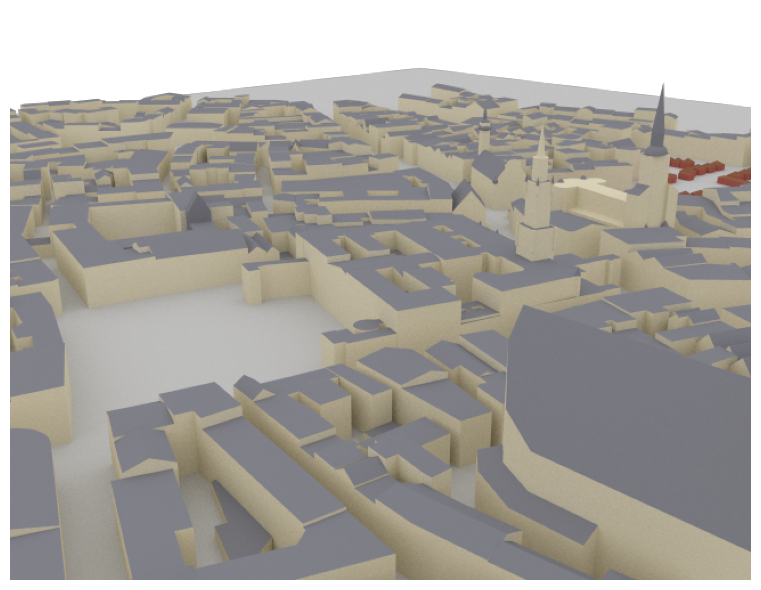

In [ ]:
# Create new camera with different configuration
my_cam = Camera(position=[-250,250,150], look_at=[-15,30,28])

# Render scene with new camera*
scene.render(camera=my_cam, resolution=[650, 500], num_samples=512); # Increase num_samples to increase image quality

## Inspecting SceneObjects and Editing of Scenes

Uma cena consiste em múltiplos [SceneObjects](https://nvlabs.github.io/sionna/rt/api/scene_object.html) que podem ser acessados da seguinte maneira:

In [ ]:
scene = load_scene(sionna.rt.scene.simple_street_canyon, merge_shapes=False)
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x27e9a8a7b60>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x27e9a8e9ef0>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x27ecc00de10>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x27ecc07ca10>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x27e9a8e7050>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x27e9a8e4e90>,
 'floor': <sionna.rt.scene_object.SceneObject at 0x27ecc072150>}

In [ ]:
floor = scene.get("floor")

Os SceneObjects podem ser transformados pelas seguintes propriedades e métodos:
- position
- orientation
- scaling
- look_at

In [ ]:
print("Position (x,y,z) [m]: ", floor.position)
print("Orientation (alpha, beta, gamma) [rad]: ", floor.orientation)
print("Scaling: ", floor.scaling)

Position (x,y,z) [m]:  [[-0.769669, 0.238537, -0.0307941]]
Orientation (alpha, beta, gamma) [rad]:  [[0, 0, 0]]
Scaling:  [[1, 1, 1]]


Mais detalhes sobre essas funcionalidades podem ser encontrados no [Tutorial on Loading and Editing of Scenes](https://nvlabs.github.io/sionna/rt/tutorials/Scene-Edit.html).

Cada SceneObject possui outra propriedade importante, o vetor `velocity`:

In [ ]:
print("Velocity (x,y,z) [m/s]: ", floor.velocity)

Velocity (x,y,z) [m/s]:  [[0, 0, 0]]


Esta propriedade é utilizada durante o processo de ray tracing para calcular um desvio Doppler para cada caminho de propagação. Esta informação pode então ser usada para calcular sinteticamente a evolução temporal das respostas impulsivas do canal. Mais detalhes sobre este tópico são fornecidos no [Tutorial sobre Mobilidade](https://nvlabs.github.io/sionna/rt/tutorials/Mobility.html).

A última propriedade dos SceneObjects que discutimos aqui é o [RadioMaterial](https://nvlabs.github.io/sionna/rt/api/radio_materials.html):

In [ ]:
floor.radio_material

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.123
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

O material de rádio determina como um objeto interage com as ondas de rádio incidentes. Para saber mais sobre materiais de rádio e como eles podem ser modificados, convidamos você a dar uma olhada no Guia do Desenvolvedor sobre [Understanding Radio Materials](https://nvlabs.github.io/sionna/rt/developer/dev_custom_radio_materials.html).

Dependendo do tipo de material de rádio, algumas de suas propriedades podem mudar em função da frequência da onda de rádio incidente:

In [ ]:
scene.frequency = 28e9 # in Hz; implicitly updates RadioMaterials that implement frequency dependent properties
floor.radio_material # Note that the conductivity (sigma) changes automatically

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.626
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

## Ray tracing de Caminhos de Propagação

Uma vez que uma cena é carregada, podemos posicionar Transmissores e Receptores nela e calcular os caminhos de propagação entre eles.
Todos os transmissores e todos os receptores estão equipados com os mesmos arrays de antenas, que são definidos pelas propriedades da `scene` `scene.tx_array` e `scene.rx_array`, respectivamente. Arrays de antenas são compostos por múltiplas antenas idênticas. As antenas podem ter padrões personalizados ou pré-definidos e são de polarização única ou dupla. Uma cena pode conter múltiplos transmissores e receptores, desde que tenham nomes únicos.

Mais detalhes sobre padrões de antena podem ser encontrados no Guia do Desenvolvedor [Understanding Radio Materials](https://nvlabs.github.io/sionna/rt/developer/dev_custom_radio_materials.html).

In [ ]:
scene = load_scene(sionna.rt.scene.munich, merge_shapes=True) # Merge shapes to speed-up computations

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27],
                 display_radius=2)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[45,90,1.5],
              display_radius=2)

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

Os caminhos de propagação são calculados com a ajuda de um [PathSolver](https://nvlabs.github.io/sionna/rt/api/paths_solvers.html).
A próxima célula mostra como tal resolvedor de caminhos é instanciado e utilizado.

O parâmetro `max_depth` determina o número máximo de interações entre um raio e os objetos da cena.
Por exemplo, com um `max_depth` igual a zero, apenas os caminhos LOS (linha de visada) são considerados. Para um `max_depth` igual a um, são considerados tanto LOS quanto reflexões ou refrações de primeira ordem. Quando o argumento `synthetic_array` é definido como `False`, os arrays de antenas são explicitamente modelados encontrando caminhos entre qualquer par de antenas transmissoras e receptoras na cena. Caso contrário, os arrays são representados por uma única antena localizada no centro do array.
Deslocamentos de fase relacionados às posições relativas das antenas serão então aplicados com base numa suposição de onda plana quando as respostas impulsivas do canal são calculadas.

In [ ]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

O objeto [Paths](https://nvlabs.github.io/sionna/rt/paths.html) contém todos os caminhos que foram encontrados entre transmissores e receptores.
Em princípio, a existência de cada caminho é determinística para uma determinada posição e ambiente. Observe que, devido à natureza estocástica do algoritmo *shoot-and-bounce*, execuções diferentes do resolvedor de caminhos podem resultar em caminhos diferentes sendo encontrados. Mais importante ainda, os caminhos refletidos difusamente são obtidos por meio de amostragem aleatória de direções após cada interação com um objeto da cena. Você pode fornecer o argumento `seed` ao solver para garantir reprodutibilidade.

Vamos agora visualizar os caminhos encontrados na cena:

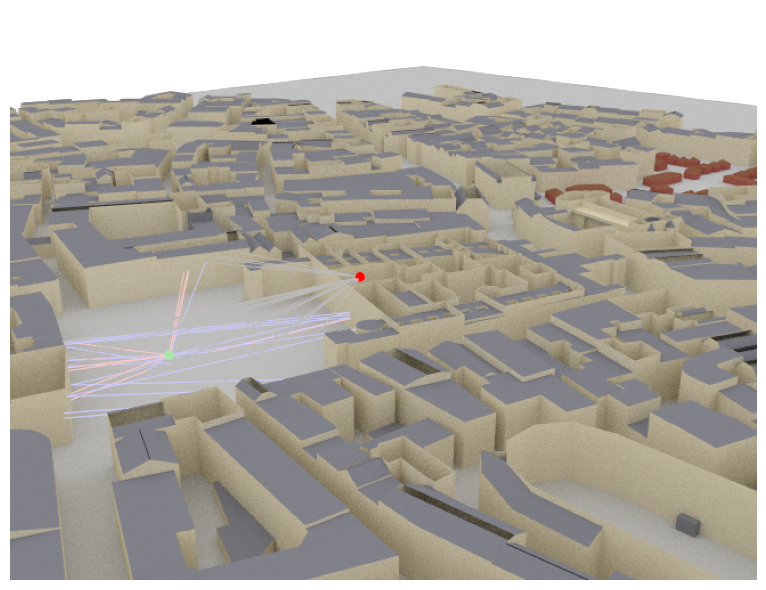

In [ ]:
if no_preview:
    scene.render(camera=my_cam, paths=paths, clip_at=20);
else:
    scene.preview(paths=paths, clip_at=20);

O objeto Paths contém informações detalhadas sobre cada caminho encontrado e nos permite gerar respostas impulsivas do canal e aplicar desvios Doppler para a simulação da evolução temporal. Para uma descrição detalhada, consulte o guia do desenvolvedor [Understanding the Paths Object](https://nvlabs.github.io/sionna/rt/developer/dev_understanding_paths.html).

## From Paths to Channel Impulse and Frequency Responses

Uma vez que os caminhos são calculados, eles podem ser transformados em uma resposta impulsiva do canal equivalente em banda base (CIR) através de [Paths.cir()](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.cir), em uma resposta impulsiva do canal discreta complexa equivalente em banda base através de [Paths.taps()](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.taps), ou em uma resposta de frequência do canal (CFR) através de [Paths.cfr()](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.cfr). Estes métodos de classe podem simular a evolução temporal do canal com base nos desvios Doppler calculados (consulte [Paths.doppler](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.doppler)).

Vamos primeiro derivar e visualizar a resposta impulsiva do canal equivalente em banda base a partir dos caminhos calculados acima::

In [ ]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

Shape of a:  (1, 2, 1, 1, 21, 1)
Shape of tau:  (1, 2, 1, 1, 21)


O argumento `out_type` pode ser usado para converter o CIR em tensores de diferentes frameworks, como [Dr.Jit](https://drjit.readthedocs.io/en/latest/reference.html) ("drjit"), [Numpy](https://numpy.org) ("numpy"),
            [Jax](https://jax.readthedocs.io/en/latest/index.html) ("jax"),
            [TensorFlow](https://www.tensorflow.org) ("tf"),
            e [PyTorch](https://pytorch.org) ("torch"). Consulte o guia do desenvolvedor [Compatibility with other Frameworks](https://nvlabs.github.io/sionna/rt/developer/dev_compat_frameworks.html) para obter mais informações sobre a interoperabilidade do Sionna RT com outros frameworks de arrays, incluindo a propagação de gradientes.

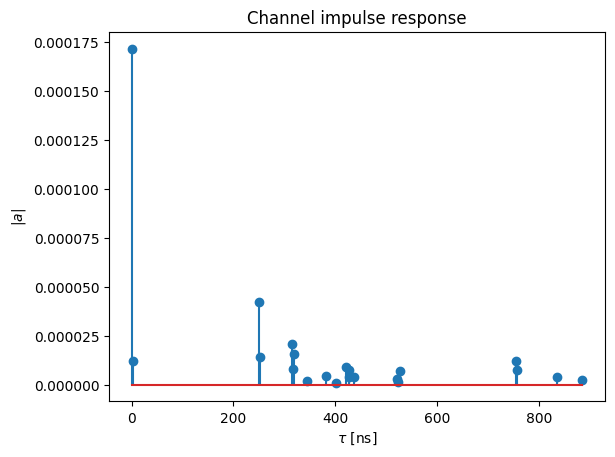

In [ ]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

Observe que o atraso do primeiro caminho que chega é por padrão normalizado para zero. Este comportamento pode ser alterado definindo o argumento ``normalize_delays`` como `True`.

Podemos obter a resposta de frequência do canal de maneira similar:

Shape of h_freq:  (1, 2, 1, 1, 1, 1024)


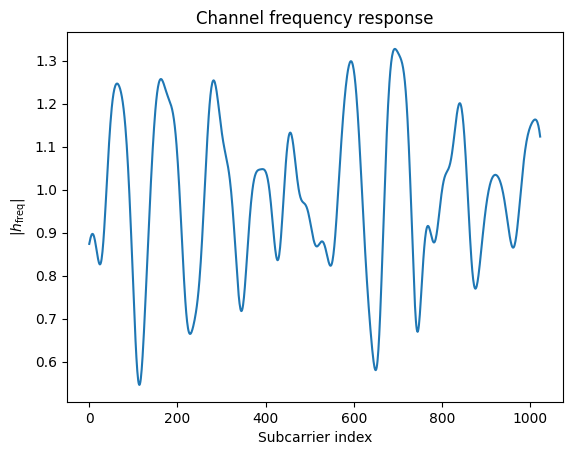

In [ ]:
# OFDM system parameters
num_subcarriers = 1024
subcarrier_spacing=30e3

# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

# Compute channel frequency response
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq.shape)

# Plot absolute value
plt.figure()
plt.plot(np.abs(h_freq)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");

Para simulações de nível de link no domínio do tempo, frequentemente requeremos a resposta impulsiva do canal equivalente em banda base discreta ou simplesmente os taps do canal.
Estes são obtidos amostrando a resposta impulsiva do canal idealmente filtrada passa-baixa na frequência de amostragem desejada. Por padrão, assume-se que a amostragem é realizada na taxa de Nyquist.

Como o filtro sinc subjacente possui uma resposta infinitamente longa, os taps do canal precisam ser truncados em um valor mínimo e máximo, ou seja, `l_min` e `l_max`, respectivamente.

Shape of taps:  (1, 2, 1, 1, 1, 107)


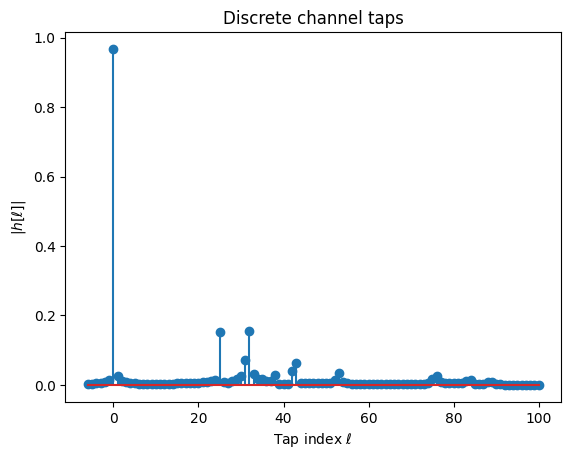

In [ ]:
taps = paths.taps(bandwidth=100e6, # Bandwidth to which the channel is low-pass filtered
                  l_min=-6,        # Smallest time lag
                  l_max=100,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.arange(-6, 101), np.abs(taps)[0,0,0,0,0]);
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");

Cada dispositivo de rádio e objeto de cena possui um vetor de velocidade associado a ele. Estes são usados para calcular desvios Doppler específicos de caminho que permitem a simulação de mobilidade. Mais detalhes podem ser encontrados no [Tutorial sobre Mobilidade](https://nvlabs.github.io/sionna/rt/tutorials/Mobility.html).

Agora vamos atribuir um vetor de velocidade não nulo ao transmissor, recalcular os caminhos de propagação e calcular uma resposta impulsiva do canal variante no tempo:

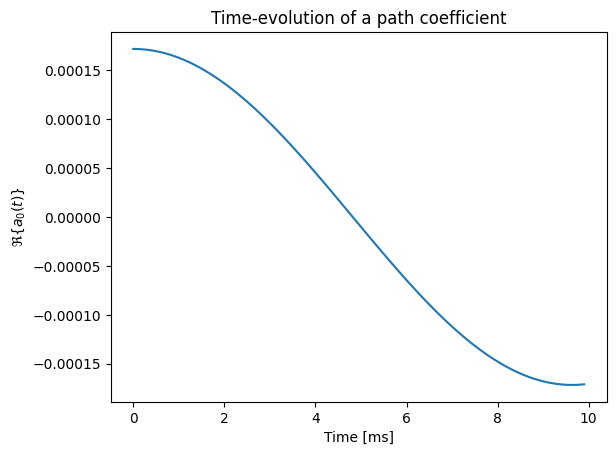

In [ ]:
scene.get("tx").velocity = [10, 0, 0]

# Recompute propagation paths
paths_mob = p_solver(scene=scene,
                     max_depth=5,
                     los=True,
                     specular_reflection=True,
                     diffuse_reflection=False,
                     refraction=True,
                     synthetic_array=True,
                     seed=41)

# Compute CIR with time-evolution
num_time_steps=100
sampling_frequency = 1e4
a_mob, _ = paths_mob.cir(sampling_frequency=sampling_frequency,
                         num_time_steps=num_time_steps,
                         out_type="numpy")

# Inspect time-evolution of a single path coefficient
plt.figure()
plt.plot(np.arange(num_time_steps)/sampling_frequency*1000,
         a_mob[0,0,0,0,0].real);
plt.xlabel("Time [ms]");
plt.ylabel(r"$\Re\{a_0(t) \}$");
plt.title("Time-evolution of a path coefficient");

## Radio Maps

O Sionna RT pode calcular mapas de rádio para todos os transmissores em uma cena. Um [RadioMap](https://nvlabs.github.io/sionna/rt/api/radio_maps.html) atribui uma métrica, como ganho de percurso, força do sinal recebido (RSS) ou relação sinal-interferência-mais-ruído (SINR), para um transmissor específico em cada ponto de um plano. Em outras palavras, para um determinado transmissor, ele associa cada ponto em uma superfície com o ganho de canal, RSS ou SINR que um receptor com uma orientação específica observaria nesse ponto.

Assim como o cálculo dos caminhos de propagação requer um [PathSolver](https://nvlabs.github.io/sionna/rt/api/paths_solvers.html), o cálculo de mapas de rádio requer um [RadioMapSolver](https://nvlabs.github.io/sionna/rt/api/radio_map_solvers.html). O seguinte trecho de código mostra como um mapa de rádio pode ser calculado e exibido.

Mais informações sobre mapas de rádio podem ser encontradas no detalhado [Tutorial on Radio Maps](https://nvlabs.github.io/sionna/rt/tutorials/Radio-Maps.html).

In [ ]:
rm_solver = RadioMapSolver()

rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[1,1],
               samples_per_tx=10**6)

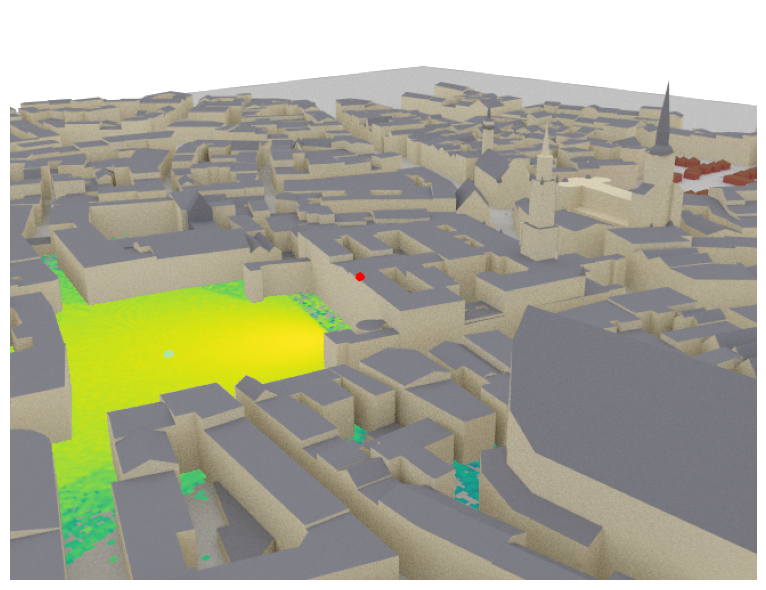

In [ ]:
if no_preview:
    scene.render(camera=my_cam, radio_map=rm);
else:
    scene.preview(radio_map=rm);

## Resumo

Neste tutorial, você aprendeu os fundamentos do Sionna RT. Agora você sabe como os caminhos podem ser encontrados em ambientes complexos e como a CIR, CFR e os taps podem ser derivados a partir deles. Você também aprendeu como os mapas de rádio podem ser criados.

Há uma característica fundamental do Sionna RT que não foi discutida neste notebook: Cálculo automático de gradientes.
Como a maioria dos componentes do Sionna, o Sionna RT também é diferenciável em relação à maioria dos parâmetros, como materiais de rádio, padrões de dispersão e antena, orientações de transmissor e receptor, geometrias de array, posições, etc.

Por favor, consulte a [documentação da API](https://nvlabs.github.io/sionna/rt/api/rt.html) dos diversos componentes e os outros [Tutoriais](https://nvlabs.github.io/sionna/rt/tutorials.html) e [Guias do Desenvolvedor](https://nvlabs.github.io/sionna/rt/developer/developer.html) disponíveis.